In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 18
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [33]:
### --- M = 1 limit cycle network --- ###

N = 2000
M = 1
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2
D = D1*np.ones(N_tasks)
D[0] = 2.2

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    #sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100
dt = 0.05
N_runs = 180
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 50
    elif i_run > 2*N_runs//3:
        ic_std = 10
    else:
        ic_std = 2
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    #x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 #+ x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:, :, 2:4], r) * D[None,:,None,None]

0


In [34]:
np.savez('packaged_results/M1M2_stuff/M=1_limcyc', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

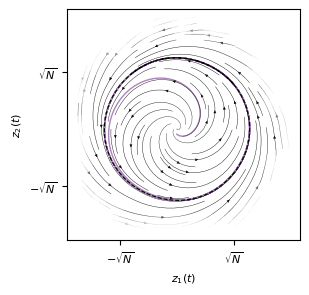

In [9]:
all_batches = list(Zs[:,0,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,0,:,:]), limit_cycle=Z_long2[0,0,9700:], plot_only_first=True, fgsz=3)

In [35]:
### --- M = 1 fp network --- ###

N = 2000
M = 2
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2
D = D1*np.ones(N_tasks)
D[0] = 0

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    #sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100
dt = 0.05
N_runs = 180
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 50
    elif i_run > 2*N_runs//3:
        ic_std = 10
    else:
        ic_std = 2
    #x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_2 #+ x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:, :, 2:4], r) * D[None,:,None,None]

0


In [36]:
np.savez('packaged_results/M1M2_stuff/M=1_fp', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

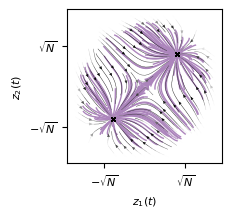

In [19]:
all_batches = list(Zs[:,1,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot t he flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,1,:,:]), limit_cycle=None, plot_only_first=False, fgsz=2,
                                      plot_endpoints=True)

In [23]:
### --- M = 2 network --- ###

N = 2000
M = 2
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2
D = D1*np.ones(N_tasks)
D[0] = 2.2

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=0)
T_sim = 100
dt = 0.05
N_runs = 180
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 50
    elif i_run > 2*N_runs//3:
        ic_std = 10
    else:
        ic_std = 2
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = 1*x0_1 + 0*x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:, :, 2:4], r) * D[None,:,None,None]

0


In [24]:
np.savez('packaged_results/M1M2_stuff/M=2_for_limcyc.npz', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

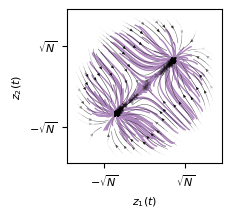

In [28]:
# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,1,:140,:]), limit_cycle=None, plot_only_first=False, fgsz=2,
                                      plot_endpoints=True)

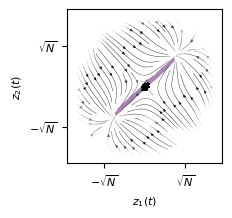

In [29]:
# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,1,140:,:]), limit_cycle=None, plot_only_first=False, fgsz=2,
                                      plot_endpoints=True)

In [13]:
### --- M = 2 FP WINS network --- ###

N = 2000
M = 2
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2.2
D = D1*np.ones(N_tasks)
D[0] = 2

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=1)
T_sim = 100
dt = 0.05
N_runs = 180
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 50
    elif i_run > 2*N_runs//3:
        ic_std = 10
    else:
        ic_std = 2
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = 1*x0_1 + 1*x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:, :, 2:4], r) * D[None,:,None,None]

1


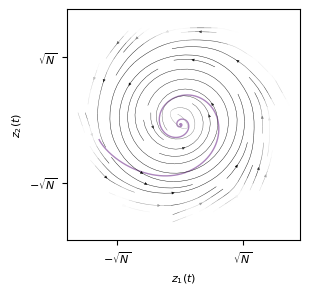

In [18]:
all_batches = list(Zs[:,0,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[62:,0,:,:]), limit_cycle=None, plot_only_first=True, fgsz=3)

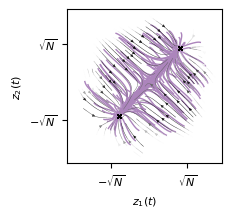

In [19]:
all_batches = list(Zs[:,1,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot t he flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,1,:,:]), limit_cycle=None, plot_only_first=False, fgsz=2,
                                      plot_endpoints=True)

In [20]:
np.savez('packaged_results/M1M2_stuff/M=2_FP_wins.npz', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [32]:
### --- M ~ N network --- ###

N = 2000
M = 1000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2
D = D1*np.ones(N_tasks)
D[0] = 3

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100
dt = 0.05
N_runs = 1200
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 10
    elif i_run > 2*N_runs//3:
        ic_std = 5
    else:
        ic_std = 2
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    #x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = 1*x0_1# + 0*x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:2, :, 2:4], r) * D[None,:2,None,None]

496


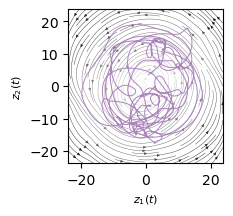

(-23.75, 23.75, -23.75, 23.75)

In [34]:
all_batches = list(Zs[:,0,:,:])

R = 25
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot t he flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=None, limit_cycle=None, plot_only_first=True, fgsz=2, plot_arrows=True,
                                      plot_endpoints=False, sqrt_ticks=False, Z_long=Z_long2[0,0,:,:])
ax = fig.gca()
ax.axis('equal')

In [35]:
np.savez('packaged_results/M1M2_stuff/M=1000_rotations', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [ ]:
all_batches = list(Zs[:,0,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,0,:,:]), limit_cycle=Z_long2[0,0,9700:], plot_only_first=True, fgsz=3)

all_batches = list(Zs[:,1,:300,:])

R = 120
#R = 15
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[5:6,1,:,:]), limit_cycle=None, plot_only_first=False, fgsz=3,
                                       xlimylim=45, plot_endpoints=True)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[4:5,1,:,:]), limit_cycle=None, plot_only_first=False, fgsz=3,
                                       xlimylim=45, plot_endpoints=True)

ax = fig.gca()
ax.plot([Zs[4,1,-1,0]], [Zs[4,1,-1,1]], 'x', color='k')

ax.plot([all_batches[0][-1,0]], [all_batches[0][-1,1]], 'x', color='k')

fig

all_batches = list(Zs[:,2,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[::10,2,:,:]), sqrt_ticks=False,
                                       limit_cycle=None, plot_only_first=False, fgsz=3, plot_endpoints=True)

In [ ]:
processed_data = np.array([])

In [25]:
### --- M ~ N network --- ###

N = 4000
M = 500
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
M1 = M
D1 = 2
D = D1*np.ones(N_tasks)
D[0] = 3
D1 = D.copy()

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z1 = np.einsum('air, ti -> atr', all_loadings[:,:,2:4], r) * D[:,None,None]

290


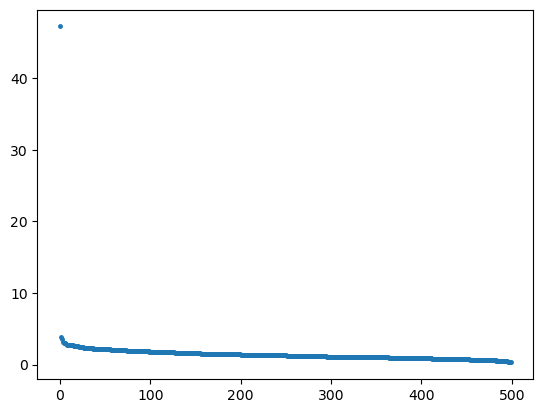

In [8]:
#spec = sorted([np.sqrt(Z1[i_task,:,0].var() + Z1[i_task,:,1].var())/D[i_task] for i_task in range(M1)])[::-1]
spec1 = sorted([np.sqrt(Z1[i_task]**2).sum(-1).mean()/D1[i_task] for i_task in range(M1)])[::-1]
plt.plot(np.arange(M1), spec1, '.', markersize=5)
#plt.ylim([0, 40])

In [26]:
### --- M ~ N network --- ###

N = 4000
M = 2500
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
M2 = M
D1_ = 2
D = D1_*np.ones(N_tasks)
D[0] = 3
D2 = D.copy()

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z2 = np.einsum('air, ti -> atr', all_loadings[:,:,2:4], r) * D[:,None,None]

1279


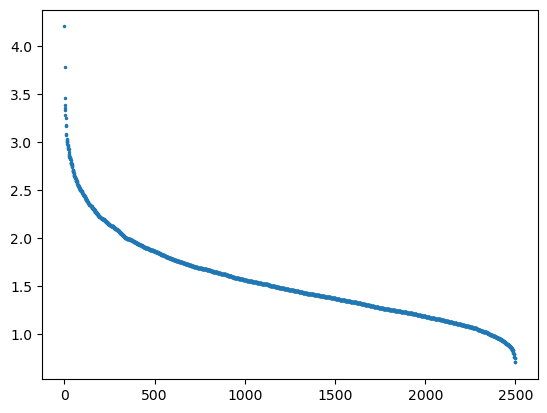

In [11]:
#spec = sorted([np.sqrt(Z2[i_task,:,0].var() + Z2[i_task,:,1].var())/D[i_task] for i_task in range(M2)])[::-1]
spec2 = sorted([np.sqrt(Z2[i_task]**2).sum(-1).mean()/D2[i_task] for i_task in range(M2)])[::-1]
plt.plot(np.arange(M2), spec2, '.', markersize=3)

#plt.ylim([0, 40])

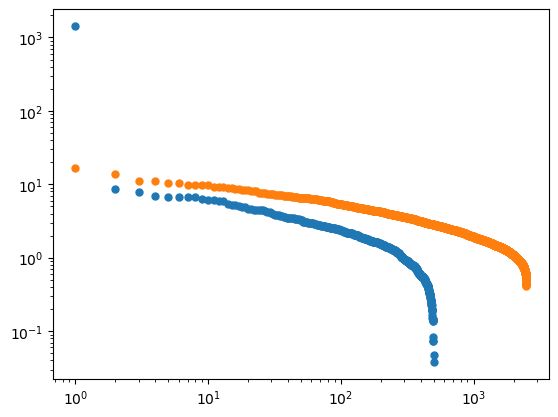

In [27]:
spec1 = sorted([(Z1[i_task]**2).sum(-1).mean()/D1[i_task]**2 for i_task in range(M1)])[::-1]
plt.plot(np.arange(1,M1+1), spec1, '.', markersize=10)
spec2 = sorted([(Z2[i_task]**2).sum(-1).mean()/D2[i_task]**2 for i_task in range(M2)])[::-1]
plt.plot(np.arange(1,M2+1), spec2, '.', markersize=10)
#plt.ylim([0, 40])
plt.xscale('log')
plt.yscale('log')

In [20]:
(Z1[0]**2).sum(-1).mean()

12341.42599257965

In [69]:
np.savez('packaged_results/M500_M2500_2.npz', spec1=spec1, spec2=spec2)

<BarContainer object of 300 artists>

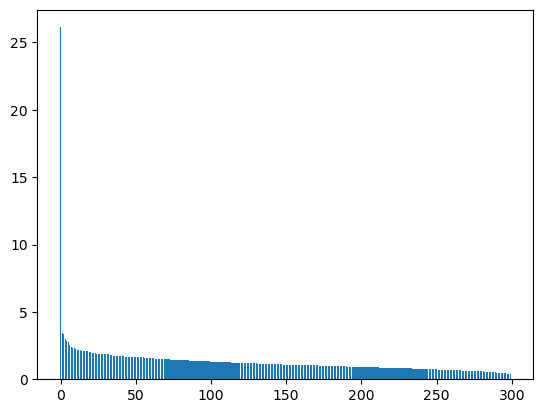

In [23]:
plt.bar(np.arange(M), sorted([np.sqrt(Z[i_task,:,0].var() + Z[i_task,:,1].var())/D[i_task] for i_task in range(M)])[::-1])

<BarContainer object of 40 artists>

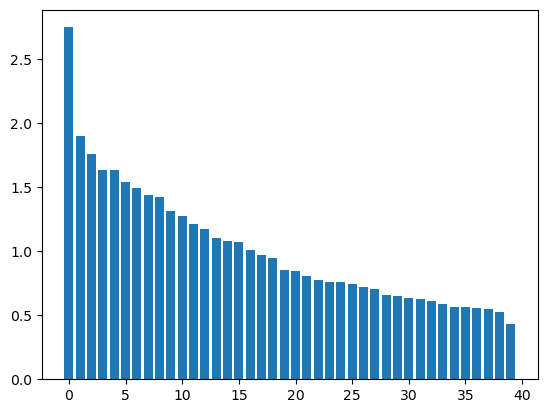

In [84]:
plt.bar(np.arange(40), sorted([np.sqrt(Z[i_task,:,0].var() + Z[i_task,:,1].var())/D[i_task] for i_task in range(40)])[::-1])

<BarContainer object of 20 artists>

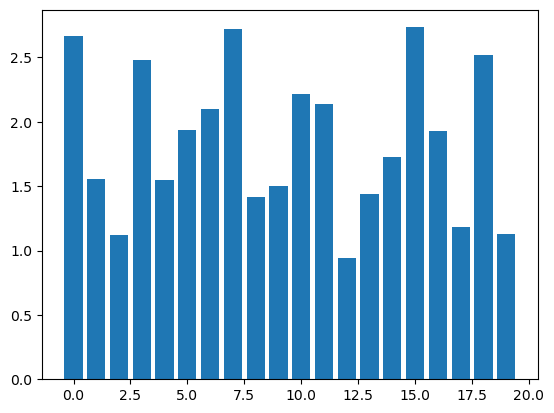

In [48]:
plt.bar(np.arange(20), [np.sqrt(Z[i_task,:,0].var() + Z[i_task,:,1].var()) for i_task in range(20)])

In [94]:
### --- M = 2 elliptical network --- ###

N = 2000
M = 2
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2.2
D = D1*np.ones(N_tasks)
D[0] = 4

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.6, -0.4], [0.4, 0.2]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=0)
T_sim = 400
dt = 0.05
N_runs = 12
Zs = []
for i_run in range(N_runs):
    if i_run > N_runs//3:
        ic_std = 50
    elif i_run > 2*N_runs//3:
        ic_std = 10
    else:
        ic_std = 2
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 + 1*x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]
x, r = sample_activity(T_sim=500, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None, N_batch=10,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, tbi -> batr', all_loadings[:, :, 2:4], r) * D[None,:,None,None]

0


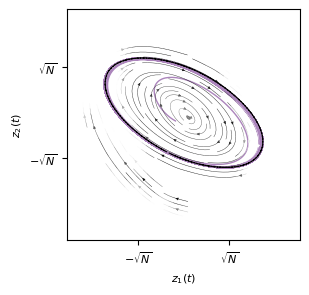

In [95]:
all_batches = list(Zs[:,0,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,0,:,:]), limit_cycle=Z_long2[0,0,9700:], plot_only_first=True, fgsz=3)

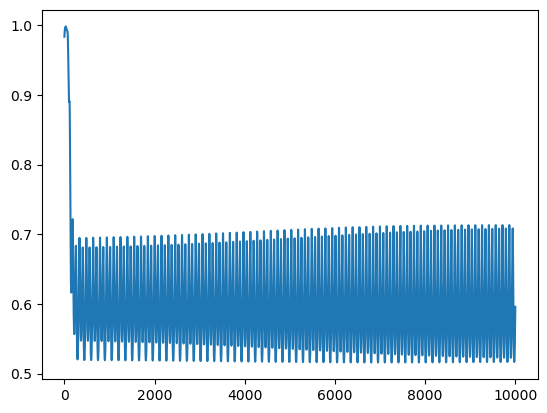

In [96]:
plt.plot(phi_prime_numpy(x[:,0,:]).mean(1))

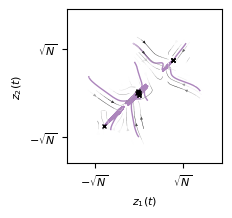

In [97]:
all_batches = list(Zs[:,1,:,:])

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot t he flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, N=N, density=1.5, linewidth=0.3, arrowsize=0.4,
                                 Z=list(Zs[:,1,:,:]), limit_cycle=None, plot_only_first=False, fgsz=2,
                                      plot_endpoints=True)

In [72]:
np.linalg.eigvals(sigma_mn_all[:,:,0])

array([0.4+0.34641016j, 0.4-0.34641016j])

(-10.0, 10.0)

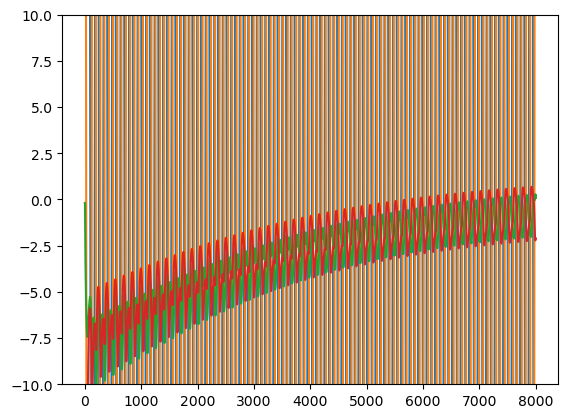

In [107]:
i_run = 7
plt.plot(Zs[i_run,0,:,0])
plt.plot(Zs[i_run,0,:,1])
plt.plot(Zs[i_run,1,:,0])
plt.plot(Zs[i_run,1,:,1])
plt.ylim([-10, 10])

In [15]:
### --- M = 2 double elliptical network --- ###

N = 8000
M = 2
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
R = 2
N_tasks = M
D1 = 2.7
D = D1*np.ones(N_tasks)
D[0] = 3

sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.6, -0.4], [0.4, 0.2]])
if M >= 2:
    sigma_mn_all[:,:,1] = np.array([[0.2, -0.4], [0.4, 0.6]])
    #sigma_mn_all[:,:,1] = np.array([[0.45, 0.3],[0.3, 0.45]])

W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=0)
T_sim = 400
dt = 0.05
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r) * D[:,None,None]

0


In [8]:
np.linalg.eigvals(sigma_mn_all[:,:,0])

array([0.4+0.34641016j, 0.4-0.34641016j])

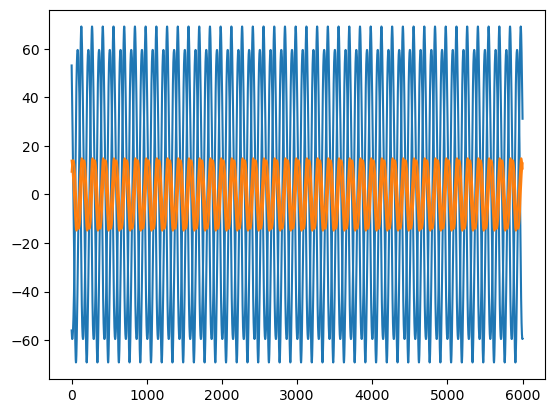

In [16]:
plt.plot(Z[0,:,0], color='C0')
plt.plot(Z[0,:,1], color='C0')
plt.plot(Z[1,:,0], color='C1')
plt.plot(Z[1,:,1], color='C1')

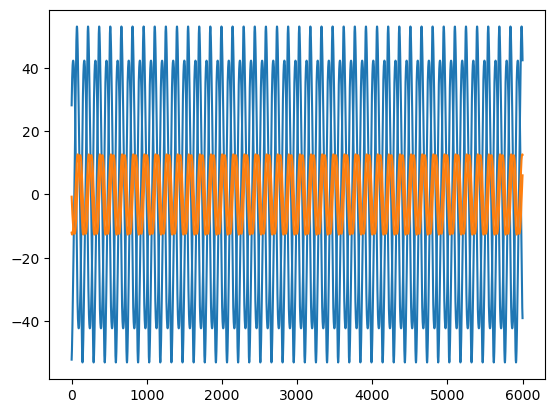

In [12]:
plt.plot(Z[0,:,0], color='C0')
plt.plot(Z[0,:,1], color='C0')
plt.plot(Z[1,:,0], color='C1')
plt.plot(Z[1,:,1], color='C1')

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [73]:
###Truncate file above
file_name = 'Figure_2_increase_M'
job_name = 'radii_avg_gains_3'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Figure_2_increase_M.ipynb to script
[NbConvertApp] Writing 15894 bytes to Figure_2_increase_M.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b76a50f1ad0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b76a50f1ad0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [74]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='Multi_Task_Elife')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='Multi_Task_Elife', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/Multi_Task_Elife/radii_avg_gains_3/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/condensed_tasks.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft

In [75]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4959746    lkumar  jupyter   om2382  R   22:54:49      1 ax14


In [76]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'radii_avg_gains_3'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [70]:
theory_results[1].shape

(18, 2, 400)

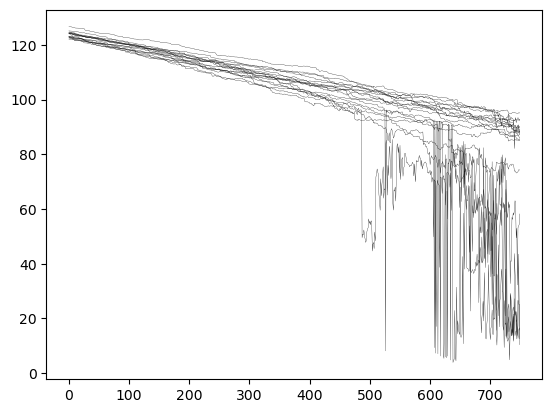

In [77]:
for i_seed in range(18):
    plt.plot(theory_results[1][i_seed,0,:], color='k', linewidth=0.2)

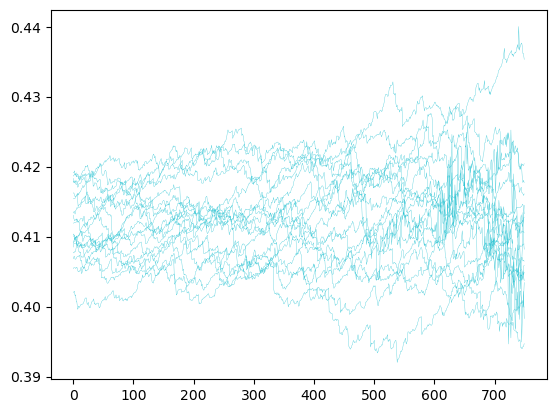

In [78]:
for i_seed in range(18):
    plt.plot(theory_results[1][i_seed,1,:], color='C9', linewidth=0.2)